# Presynaptic profiles analysis

---

Pre-synaptic axonal terminals with GCamp5f

In [39]:
import sys
import os
import yaml

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import peakutils

from scipy import signal
from scipy import stats
from scipy import ndimage

from skimage import io
from sklearn import preprocessing

## Full frame analysis

### Data & metadata uploading

#### Single data

In [ ]:
samp_name = 'A0011'
samp_path = os.path.join(''.join(sys.path[0].split('neuro')), 'data_neuro', samp_name)

# sample YAML metadata file uploading
with open(f'{samp_path}/{samp_name}_meta.yaml') as f:
    samp_meta = yaml.safe_load(f)

# sample img series uploading
img = io.imread(f'{samp_path}/{samp_name}_pre_mov_cor.tif')
plt.figure(figsize=(10,10))
plt.imshow(np.max(img, axis=0), cmap='jet')


# time parameters (from meta file)
total_reg_t = samp_meta['Reg_time']
frame_time = total_reg_t / img.shape[0]
time_line = np.linspace(0, total_reg_t, num=img.shape[0])

# treatment parameters (from meta file)
treatment_dict = {}
for samp in samp_meta['Events']:
    treat_name = f"{samp['Type']}_{samp['Freq']}"
    start_time = samp['Time']/1000
    end_time = start_time + samp['Duration']
    treatment_dict.update({treat_name:[start_time, end_time]})
for k,v in treatment_dict.items():  # app time print
    print(k, ':', np.around(v, 1))

application_lines_dict = {t:np.linspace(treatment_dict[t][0], treatment_dict[t][1]) for t in treatment_dict}


#### Multiple data

In [78]:
class pre_reg():
    """ Presynapse full-frame registration

    """
    def __init__(self, samp_name):
        self.samp_name = samp_name
        self.samp_path = os.path.join(''.join(sys.path[0].split('neuro')), 'data_neuro', samp_name)

        self.img_series = io.imread(f'{self.samp_path}/{self.samp_name}_pre_mov_cor.tif')
        self.total_prof = np.asarray([np.mean(frame) for frame in self.img_series])

        with open(f'{self.samp_path}/{self.samp_name}_meta.yaml') as f:
            self.samp_meta = yaml.safe_load(f)

        self.total_reg_t = self.samp_meta['Reg_time']
        self.frame_time = self.total_reg_t / self.img_series.shape[0]
        self.time_line = np.linspace(0, self.total_reg_t, num=self.img_series.shape[0])

        self.treat_dict, self.app_line_dict = self.treat_calc(self.samp_meta)


    @staticmethod
    def treat_calc(samp_meta):
        treat_dict = {}
        for samp in samp_meta['Events']:
            treat_name = f"{samp['Type']}_{samp['Freq']}"
            start_time = samp['Time']/1000
            end_time = start_time + samp['Duration']
            treat_dict.update({treat_name:[start_time, end_time]})
        for k,v in treat_dict.items():  # app time print
            print(k, ':', np.around(v, 1))

        application_lines_dict = {t:np.linspace(treat_dict[t][0], treat_dict[t][1]) \
                                  for t in treat_dict}
    
        return treat_dict, application_lines_dict
    

    def plot_tot_profile(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.time_line, self.total_prof)

        for line_name in self.app_line_dict:
                line_lim = self.app_line_dict[line_name]
                plt.plot(line_lim, [np.min(self.total_prof)] * len(line_lim), label=line_name, linewidth=4)

        plt.xlabel('Time, s')
        plt.ylabel('I, a.u.')
        plt.title(f'{self.samp_name}, {self.samp_meta["Treat"]}')        
        plt.legend()

    def LF_stims(self, stim_ext_sec=15, min_distance_sec=8, create_df=False):

        self.min_distance_frames = int(min_distance_sec / self.frame_time)
        if self.min_distance_frames < 1:
            self.min_distance_frames = 1

        self.LF_dF_stim_prof = {}
        self.LF_stim_df = pd.DataFrame(columns=['stim',
                                                'amp_raw',
                                                'amp_dF'])

        for line_name in self.treat_dict:
                if line_name in ['A+C_0.1', 'C_0.1']:
                        t_lim = self.treat_dict[line_name]
                        time_mask = (self.time_line>=(t_lim[0]-stim_ext_sec)) & \
                                    (self.time_line<=(t_lim[1]+stim_ext_sec))

                        stim_prof_raw = self.total_prof[time_mask]
                        stim_prof_base = peakutils.baseline(stim_prof_raw, 3)
                        stim_prof = (stim_prof_raw - stim_prof_base) \
                                    + np.mean(stim_prof_base[:len(stim_prof_raw)])

                        F_0 = np.mean(stim_prof[:10])
                        dF_stim_prof = (stim_prof-F_0)/F_0
                        self.LF_dF_stim_prof.update({line_name:dF_stim_prof})

                        stim_time = self.time_line[:len(stim_prof)]

                        plt.figure(figsize=(10, 4))
                        plt.plot(stim_time, stim_prof)
                        # plt.plot(stim_time, peakutils.prepare.scale(stim_prof_raw)[0])
                        # plt.plot(stim_time, peakutils.prepare.scale(stim_prof)[0],
                        #          linestyle='--')
                        plt.title(f'{self.samp_name}, {line_name} norm., baseline extraction')

                        if create_df:
                            peaks, properties = signal.find_peaks(dF_stim_prof,
                                                                height=np.max(dF_stim_prof)*0.25,
                                                                distance=self.min_distance_frames)
                            
                            stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                                    'amp_raw':stim_prof[peaks],
                                                    'amp_dF':dF_stim_prof[peaks]})
                            self.LF_stim_df = pd.concat([self.LF_stim_df, stim_df],
                                                        ignore_index=True)

                            plt.figure(figsize=(10, 4))
                            plt.plot(stim_time, dF_stim_prof)
                            plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x')
                            plt.title(f'{self.samp_name}, {line_name}')

A+C_10.0 : [36.2 38.2]
C_10.0 : [70.6 72.6]
A_10.0 : [111.1 114. ]
A+C_0.1 : [150.1 250.1]
C_0.1 : [279.3 379.3]
A+C_10-150_0.1 : [409.9 559.9]


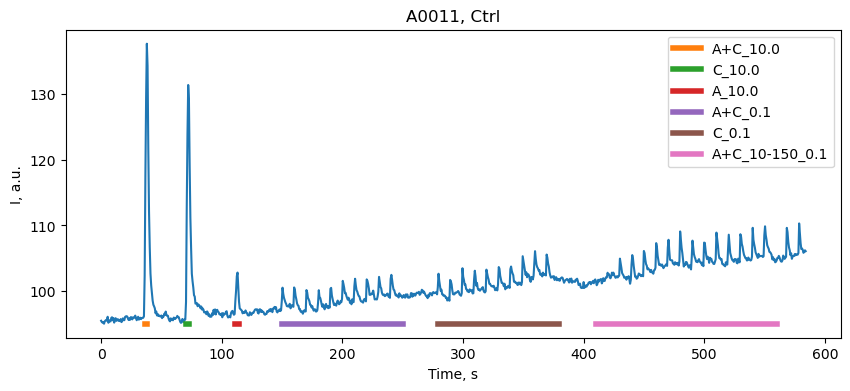

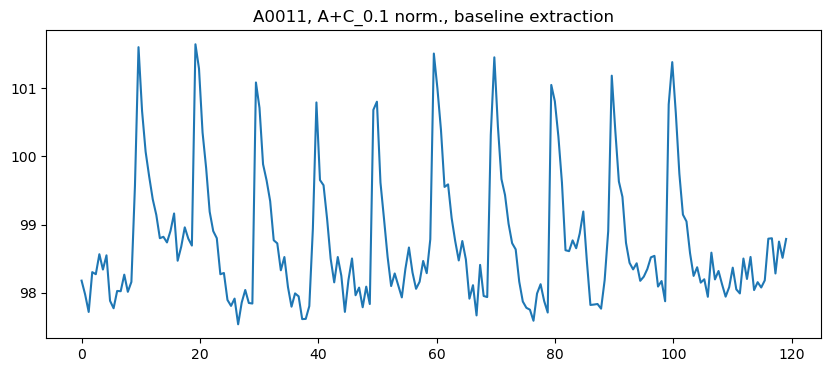

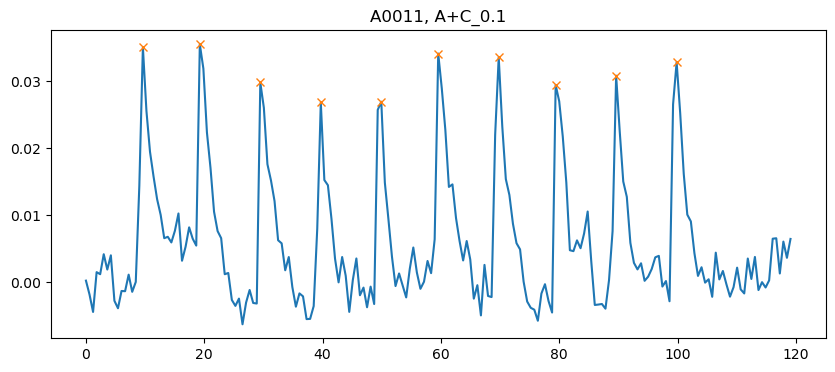

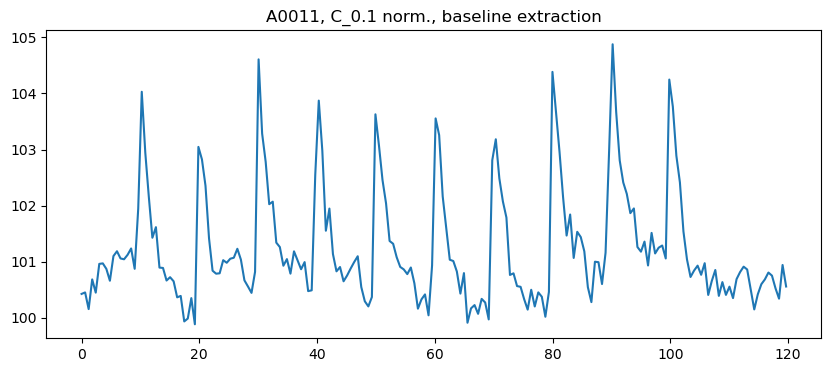

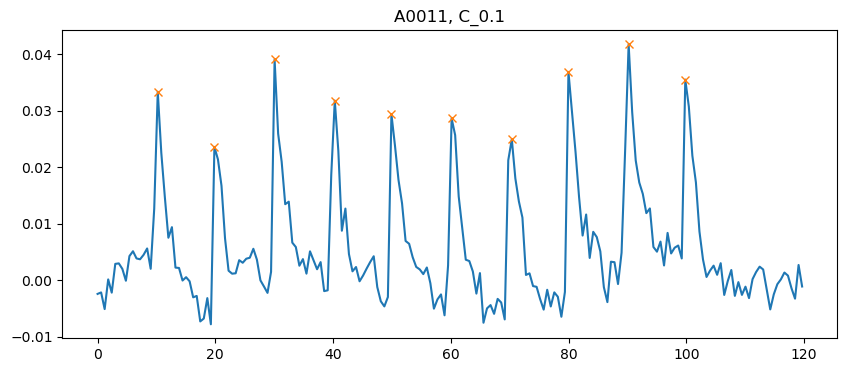

In [79]:
ctrl_reg = pre_reg('A0011')
ctrl_reg.plot_tot_profile()
ctrl_reg.LF_stims(stim_ext_sec=10, create_df=True)

# bicuc_reg = pre_reg('A0012')
# bicuc_reg.plot_tot_profile()

# glu_reg = pre_reg('A0013')
# glu_reg.plot_tot_profile()

### 0.1 Hz stim. 150 uA

Profiles

In [ ]:
stim_ext_sec = 15

min_distance_sec = 8
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

LF_dF_stim_prof = {}
LF_stim_df = pd.DataFrame(columns=['stim',
                                   'amp_raw',
                                   'amp_dF'])

for line_name in treatment_dict:
        if line_name in ['A+C_0.1', 'C_0.1']:
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & \
                            (time_line<=(t_lim[1]+stim_ext_sec))

                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0
                LF_dF_stim_prof.update({line_name:dF_stim_prof})

                stim_time = time_line[:len(stim_prof)]

                peaks, properties = signal.find_peaks(dF_stim_prof,
                                                      height=np.max(dF_stim_prof)*0.1,
                                                      distance=min_distance_frames)
                
                stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                        'amp_raw':stim_prof[peaks],
                                        'amp_dF':dF_stim_prof[peaks]})
                LF_stim_df = pd.concat([LF_stim_df, stim_df], ignore_index=True)

                plt.figure(figsize=(10, 4))
                plt.plot(stim_time, dF_stim_prof)
                plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x')
                plt.title(line_name)

Stat.

In [ ]:
group_1 = LF_stim_df['amp_dF'][LF_stim_df['stim'] == 'A+C_0.1']
group_2 = LF_stim_df['amp_dF'][LF_stim_df['stim'] == 'C_0.1']

u_val, p_val = stats.mannwhitneyu(group_1, group_2)
print(f'U-test p-value={p_val}')

fig = px.box(LF_stim_df, x='stim' , y='amp_dF', color='stim', points="all")
fig.show()

### 0.1 Hz 10-150 uA

Profile

In [ ]:
stim_ext_sec = 15

min_distance_sec = 8
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

LF_dF_up_prof = {}
LF_up_df = pd.DataFrame(columns=['stim',
                                 'time',
                                 'amp_raw',
                                 'amp_dF',
                                 'cur'])

for line_name in treatment_dict:
        if line_name in ['A+C_10-150_0.1']:
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & \
                            (time_line<=(t_lim[1]+stim_ext_sec))

                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0
                LF_dF_up_prof.update({line_name:dF_stim_prof})

                stim_time = time_line[:len(stim_prof)]

                peaks, properties = signal.find_peaks(dF_stim_prof,
                                                      height=np.max(dF_stim_prof)*0.1,
                                                      distance=min_distance_frames)
                
                # stim_val = ['150', '140', '130', '120', '110', '100', '90', '80', '70', '60', '50', '40', '30', '20', '10']
                stim_val = range(10, 160, 10)
                stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                        'time':stim_time[peaks],
                                        'amp_raw':stim_prof[peaks],
                                        'amp_dF':dF_stim_prof[peaks,],
                                        'cur': stim_val})  # list(reversed(stim_val))
                LF_up_df = pd.concat([LF_up_df, stim_df], ignore_index=True)

                plt.figure(figsize=(10, 4))
                plt.plot(stim_time, dF_stim_prof)
                plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x')
                plt.title(line_name)

Stat.

In [ ]:
fig = px.line(LF_up_df, x='cur', y='amp_dF', markers=True)
fig.show()

In [ ]:
crop_up_df = LF_up_df[LF_up_df['cur'] >= 40].drop(['time', 'cur'], axis=1)
LF_total_df = pd.concat([LF_stim_df, crop_up_df], ignore_index=True)

group_0 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'A+C_0.1']
group_1 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'C_0.1']
group_2 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'A+C_10-150_0.1']
hsd_test = stats.tukey_hsd(group_0, group_1, group_2)
print(hsd_test)

fig = px.box(LF_total_df, x='stim' , y='amp_dF', color='stim', points="all")
fig.show()

### 10 Hz stims. 150 uA

In [ ]:
stim_ext_sec = 15

HF_dF_stim_prof = {}
for line_name in treatment_dict:
        if line_name.split('_')[-1] == '10.0':
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & (time_line<=(t_lim[1]+stim_ext_sec))
                
                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0

                HF_dF_stim_prof.update({line_name:dF_stim_prof})

                plt.figure(figsize=(10, 4))
                plt.plot(time_line[:len(stim_prof)], dF_stim_prof)
                plt.title(line_name)
                # plt.plot(line_lim, [np.min(prof)] * len(line_lim), label=line_name, linewidth=4)
print(HF_dF_stim_prof.keys())